<a href="https://colab.research.google.com/github/dzisandy/Deep-Learning/blob/master/HW3/homework03_part1_both.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Neural networks for segmentation

In [1]:
# ! wget https://www.dropbox.com/s/jy34yowcf85ydba/data.zip?dl=0 -O data.zip
# ! unzip -q data.zip

Your next task is to train neural network to segment cells edges.

Here is an example of input data with corresponding ground truth:

In [2]:
import scipy as sp
import scipy.misc
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
# import warnings
# warnings.simplefilter(action='ignore')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


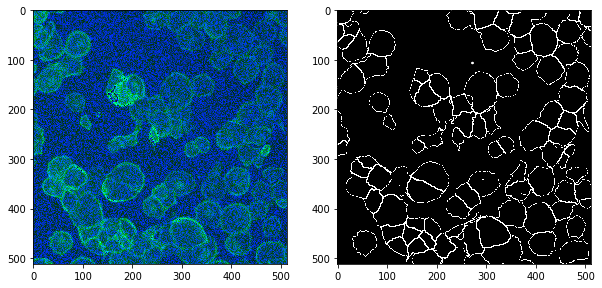

In [3]:
# Human HT29 colon-cancer cells
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
im = sp.misc.imread('BBBC018_v1_images-fixed/train/00735-actin.DIB.bmp')
plt.imshow(im)
plt.subplot(1,2,2)
mask = sp.misc.imread('BBBC018_v1_outlines/train/00735-cells.png')
plt.imshow(mask, 'gray')

This time you aren't provided with any code snippets, just input data and target metric - intersection-over-union (IoU) (see implementation below).

You should train neural network to predict mask of edge pixels (pixels in gt images with value greater than 0).

Use everything you've learnt by now: 
* any architectures for semantic segmentation (encoder-decoder like or based on dilated convolutions)
* data augmentation (you will need that since train set consists of just 41 images)
* fine-tuning

You're not allowed to do only one thing: to train you network on test set.

Your final solution will consist of an ipython notebook with code (for final network training + any experiments with data) and an archive with png images with network predictions for test images (one-channel images, 0 - for non-edge pixels, any non-zero value for edge pixels).

Forestalling questions about baseline... well, let's say that a good network should be able to segment images with iou >= 0.29. This is not a strict criterion of full points solution, but try to obtain better numbers.

Practical notes:
* There is a hard data class imbalance in dataset, so the network output will be biased toward "zero" class. You can either tune the minimal probability threshold for "edge" class, or add class weights to increase the cost of edge pixels in optimized loss.
* Dataset is small so actively use data augmentation: rotations, flip, random contrast and brightness
* Better spend time on experiments with neural network than on postprocessing tricks (i.e test set augmentation).
* Keep in mind that network architecture defines receptive field of pixel. If the size of network input is smaller than receptive field of output pixel, than probably you can throw some layers without loss of quality. It is ok to modify "of-the-shelf" architectures. 

Good luck!

In [5]:
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union

In [6]:
import os
import random
from PIL.Image import open, BILINEAR

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

from IPython import display
from tqdm import trange, tqdm

In [7]:
''' inspired by https://pytorch.org/tutorials/beginner/data_loading_tutorial.html'''
class Dataset(Dataset):
    def __init__(self, img_dir, outlines_dir, transform=None):
        super(Dataset, self).__init__()
        
        self.img = sorted(next(os.walk(img_dir))[2])
        self.outline = sorted(next(os.walk(outlines_dir))[2])
        self.img_dir = img_dir
        self.outlines_dir = outlines_dir
        self.transform = transform

    def __len__(self):
        return len(self.img)
    
    def __getitem__(self, idx):
        img = open(os.path.join(self.img_dir,self.img[idx]))
        outline = open(os.path.join(self.outlines_dir,self.outline[idx]))
        
        '''solved problem with random transformations using https://github.com/pytorch/vision/issues/9'''
        seed = np.random.randint(0,2**32)
        if self.transform:
            random.seed(seed)
            img = self.transform(img)
            random.seed(seed)
            outline = self.transform(outline)
        return img, outline



In [8]:
'''data transformation'''
train_transform = torchvision.transforms.Compose([
        torchvision.transforms.RandomRotation(5),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.RandomVerticalFlip(),
        torchvision.transforms.ToTensor()
])

val_transform = torchvision.transforms.ToTensor()
train_dataset = Dataset('BBBC018_v1_images-fixed/train', 'BBBC018_v1_outlines/train', train_transform)
train_dataloader = DataLoader(train_dataset,batch_size = 3,shuffle=True)

val_dataset = Dataset('BBBC018_v1_images-fixed/val', 'BBBC018_v1_outlines/val', val_transform)
val_dataloader = DataLoader(val_dataset,batch_size = 1,shuffle=False)



In [9]:
# U-net from the paper https://arxiv.org/pdf/1505.04597.pdf
# Implementated using some ideas from 
# https://github.com/milesial/Pytorch-UNet and https://github.com/ternaus/TernausNet

class DoubleConv2d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv2d, self).__init__()
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
    
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        return x

class Down(nn.Module):
    def __init__(self, in_channels):
        super(Down, self).__init__()
        self.max_pool = nn.MaxPool2d(kernel_size=2)
        self.double_conv = DoubleConv2d(in_channels, in_channels*2)
    
    def forward(self, x):
        x = self.max_pool(x)
        x = self.double_conv(x)
        return x

class Up(nn.Module):
    def __init__(self, in_channels):
        super(Up, self).__init__()
        self.pad = nn.ZeroPad2d((0,1,0,1))
        self.conv_up = nn.Conv2d(in_channels, in_channels//2, kernel_size=2)
        self.relu = nn.ReLU()
        self.double_conv = DoubleConv2d(in_channels, in_channels//2)
    
    def forward(self, x, copy):
        # Up-Convolution
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = self.pad(x)
        x = self.relu(self.conv_up(x))

        # Concatenate
        x = torch.cat([copy, x], dim=1)
        
        # Two Conv layers
        x = self.double_conv(x)
        return x
    
class UNet(nn.Module):
    def __init__(self, fine_tuning = None):
        super(UNet, self).__init__()
        self.predtrained = fine_tuning
        self.inp = DoubleConv2d(3, 64)
        self.down1 = Down(64)
        self.down2 = Down(128)
        self.down3 = Down(256)
        self.down4 = Down(512)
        self.up1 = Up(1024)
        self.up2 = Up(512)
        self.up3 = Up(256)
        self.up4 = Up(128)
        self.out = nn.Conv2d(64, 1, kernel_size=1)
        
        if self.predtrained:
            vgg11 = models.vgg11_bn(pretrained=True).features
            
            self.inp.conv2d_1 = vgg11[0]
            self.inp.bn_1 = vgg11[1]
            self.inp.conv2d_2 = vgg11[2]
            self.inp.bn_2 = vgg11[3]
            
            self.down1.conv2d_1 = vgg11[4]
            self.down1.bn_1 = vgg11[5]
            self.down1.conv2d_2 = vgg11[6]
            self.down1.bn_2 = vgg11[7]

            self.down2.conv2d_1 = vgg11[8]
            self.down2.bn_1 = vgg11[9]
            self.down2.conv2d_2 = vgg11[10]
            self.down2.bn_2 = vgg11[11]

            self.down3.conv2d_1 = vgg11[15]
            self.down3.bn_1 = vgg11[16]
            self.down3.conv2d_2 = vgg11[17]
            self.down3.bn_2 = vgg11[18]
            
    def forward(self, x):
        x1 = self.inp(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.out(x)
        return x

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=50, limit = 0.5,  max_iou_val = 0):    
    
    loss_history_train = []
    loss_history_val = []
    iou_history_train = []
    iou_history_val = []
    
    for epoch in trange(num_epochs):
        
        loss_train = 0
        loss_val = 0
        
        predictions_train = []
        outlines_train = []       
        predictions_val = []
        outlines_val = []

        scheduler.step() 
        
        model.train()   
        
        for train_images, train_outlines in train_dataloader:
            output = model(train_images.cuda())
            optimizer.zero_grad()
            loss = criterion(output.view(-1), train_outlines.cuda().view(-1))
            loss.backward()
            optimizer.step() 


            loss_train += loss.item() * train_images.size(0)
            pred = (output.detach().sigmoid() >= limit).cpu().numpy()
            predictions_train += [pred]
            outlines_train += [train_outlines.cpu().numpy()]
        epoch_loss_train = loss_train / len(train_dataset)
        iou_train = calc_iou(predictions_train, np.array(outlines_train))

        loss_history_train.append(epoch_loss_train)            
        iou_history_train.append(iou_train)

        model.eval()

        for val_images, val_outlines in val_dataloader:
            output = model(val_images.cuda())
            loss = criterion(output.view(-1), val_outlines.cuda().view(-1))             

            loss_val += loss.item() * val_images.size(0)
            pred = (output.detach().sigmoid() >= limit).cpu().numpy()
            predictions_val += [pred]
            outlines_val += [val_outlines.cpu().numpy()]

        epoch_loss_val = loss_val / len(val_dataset)
        predictions_val = np.concatenate(predictions_val)
        iou_val = calc_iou(predictions_val, np.array(outlines_val))

        loss_history_val.append(epoch_loss_val)
        iou_history_val.append(iou_val)
        
        if iou_val > max_iou_val:
            max_iou_val = iou_val
            best_model = torch.save(model.state_dict(), './segmentation_NN_params.pt')
        
        display.clear_output(wait=True)
        
        plt.figure(figsize = (15,4))
        plt.subplot(1,2,1)
        plt.title('Loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.plot(loss_history_train, label = 'train')
        plt.plot(loss_history_val, label = 'val')
        plt.legend()
        
        plt.subplot(1,2,2)
        plt.title('IOU, current on val {}, best on val = {}'.format(round(iou_val,4), round(max_iou_val,4)))
        plt.ylabel('iou')
        plt.xlabel('epoch')
        plt.plot(iou_history_train, label = 'train')
        plt.plot(iou_history_val, label = 'val')
        plt.legend()
        plt.show()

    return model, max_iou_val

In [11]:
summary(UNet().cuda(), (3,512,512))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]           1,792
       BatchNorm2d-2         [-1, 64, 512, 512]             128
              ReLU-3         [-1, 64, 512, 512]               0
            Conv2d-4         [-1, 64, 512, 512]          36,928
       BatchNorm2d-5         [-1, 64, 512, 512]             128
              ReLU-6         [-1, 64, 512, 512]               0
      DoubleConv2d-7         [-1, 64, 512, 512]               0
         MaxPool2d-8         [-1, 64, 256, 256]               0
            Conv2d-9        [-1, 128, 256, 256]          73,856
      BatchNorm2d-10        [-1, 128, 256, 256]             256
             ReLU-11        [-1, 128, 256, 256]               0
           Conv2d-12        [-1, 128, 256, 256]         147,584
      BatchNorm2d-13        [-1, 128, 256, 256]             256
             ReLU-14        [-1, 128, 2

In [12]:
summary(models.vgg11_bn().cuda(), (3,512,512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]           1,792
       BatchNorm2d-2         [-1, 64, 512, 512]             128
              ReLU-3         [-1, 64, 512, 512]               0
         MaxPool2d-4         [-1, 64, 256, 256]               0
            Conv2d-5        [-1, 128, 256, 256]          73,856
       BatchNorm2d-6        [-1, 128, 256, 256]             256
              ReLU-7        [-1, 128, 256, 256]               0
         MaxPool2d-8        [-1, 128, 128, 128]               0
            Conv2d-9        [-1, 256, 128, 128]         295,168
      BatchNorm2d-10        [-1, 256, 128, 128]             512
             ReLU-11        [-1, 256, 128, 128]               0
           Conv2d-12        [-1, 256, 128, 128]         590,080
      BatchNorm2d-13        [-1, 256, 128, 128]             512
             ReLU-14        [-1, 256, 1

Looking on U-Net structure I came up with idea, that I've seen familiar structure in VGG. So as finetuning i decided to input some predtrained layers from VGG11 architecture with BatchNormalization into my UNet architecture in encoder part. What is more I tried to tune threshhold and weights for classes. As the criterion i use weighted BCEWithLogitsLoss. For greater convergence I use Adam optimizer.  

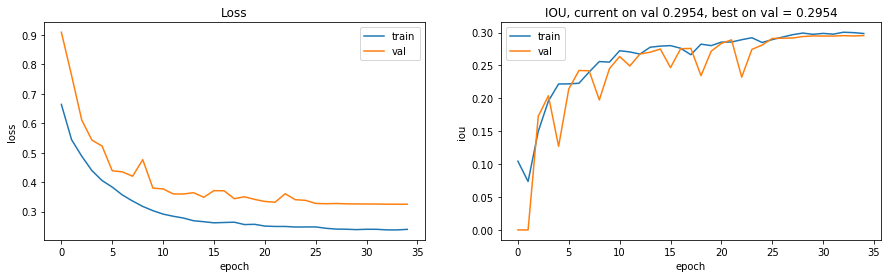

100%|██████████| 35/35 [10:08<00:00, 17.59s/it]


In [13]:
net = UNet(fine_tuning = True)
net = net.cuda()

criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(5).float().cuda())
optimizer = optim.Adam(net.parameters())
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, (25,30), gamma=.1) 
fine_net, finetune_iou = train_model(net, criterion, optimizer, scheduler, num_epochs=35 ,limit = 0.62)


In [14]:
'''function to write segmentation on test data'''
def segment_test():
    '''loading best configuration'''
    net.load_state_dict(torch.load('segmentation_NN_params.pt'))
    net.eval()
    path = sorted(next(os.walk('BBBC018_v1_images-fixed/test'))[2])
    for item in path:
        image = open('BBBC018_v1_images-fixed/test/' + item)
        inpt = torchvision.transforms.ToTensor()(image).view(1,3,512,512)
        seg = net(inpt.cuda()).cpu().view(1,512,512)
        seg = torchvision.transforms.ToPILImage()((seg > 0.6).float())
        seg.save(os.path.basename('{}segmentation.png'.format(item[:6])))

In [15]:
segment_test()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


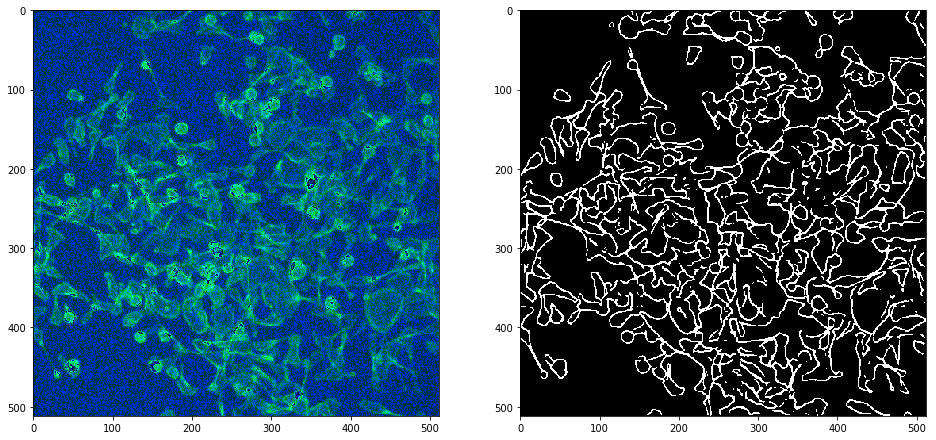

In [16]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
img = sp.misc.imread('BBBC018_v1_images-fixed/test/13361-actin.DIB.bmp')
plt.imshow(img)
plt.subplot(1,2,2)
seg = sp.misc.imread('13361-segmentation.png')
plt.imshow(seg, 'gray')
plt.show()

So as we can see, data augmentation , finetuning and hyperparameters tuning, using learning rate steper helped us achieve such a result. The given configuration satisfies the given in problem statement requirements on IoU metrics ( IoU = 0.2954), but the results hesitating some times, but in most cases more than 0.29 guaranteed. Treshhold was tuned from 0.35 to 0.65 with step 0.1, the best result was achieved at 0.62 level.